In [1]:
import os 
os.chdir("..") 
print(os.getcwd())

/Users/282066/Documents/PHD/Importance Sampling/project-root


In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from src.importance_sampling.sampling import ImportanceSampler
from src.utils.analysis_utils import summarize_all_metrics, summarize_all_deltas 
from src.utils.visualisation import plot_metric_bars, plot_metric_differences 
from src.utils.simulation_utils import generate_data, summarize_metric_differences

/Users/282066/Documents/PHD/Importance Sampling/project-root/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# generate the source data
df_source = generate_data(
    n=100000,
    p=3,
    beta_1=[1.0, 1.0, 1.0],
    beta_2=2,
    intercept=-2,
    prop_A=0.5,
    mu_A0=[0, 0, 0],
    mu_A1=[0, 0, 0],  
    sigma=2.0,
    seed=42
)
df_source['Y'].mean()

np.float64(0.40907)

In [4]:
# Initialize the model
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    df_source.drop(columns = 'Y'), df_source['Y'], df_source['A'], test_size=0.4, random_state=0)

model =  LogisticRegression()  # RandomForestClassifier()
model.fit(X_train, y_train)

yhat = model.predict(X_test)

In [5]:
# Only use part of source that that is not used to fit the Logistic model 
df_source_test = pd.DataFrame(X_test, columns=X_test.columns)
df_source_test['Y'] = y_test
df_source_test['yhat'] = yhat

### (Out of) Distribution shift simulation 

In [6]:
fixed_params = {
    "n": 10000,
    "p": 3,
}

# Define the range of means from -0.5 to 3 in steps of 0.1
mu_values = np.round(np.arange(-0.5, 3.01, 0.1), 2) 

experiment_settings = []

for mu in mu_values:
    setting = {
        "beta_1": [1, 1, 1],
        "beta_2": 2,
        "intercept": -2,
        "prop_A": 0.5,
        "mu_A0": [mu, mu, mu],
        "mu_A1": [mu, mu, mu],
        "sigma": 2.0,
    }
    experiment_settings.append(setting)

print(f"Generated {len(experiment_settings)} experiment settings.")


Generated 36 experiment settings.


In [7]:
results_plot = []

# Constants
N_SAMPLES = 5000
N_ITERS = 100
IGNORE_COLUMNS = []
SEED_BASE = 42

for i, setting in enumerate(experiment_settings, start=1):
    print(f"Running Experiment {i}")

    df_target = generate_data(
        **fixed_params,
        beta_1=setting["beta_1"],
        beta_2=setting["beta_2"],
        intercept=setting["intercept"],
        prop_A=setting["prop_A"],
        mu_A0=setting["mu_A0"],
        mu_A1=setting["mu_A1"],
        sigma=setting["sigma"],
        seed=SEED_BASE + i
    )

    df_target['yhat'] = model.predict(df_target.drop(columns='Y'))

    # Importance Sampling
    imp = ImportanceSampler(source=df_source_test, target=df_target, ignore_cols=IGNORE_COLUMNS)
    imp.fit()
    df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)

    # Collect datasets for metric comparison
    datasets = {
        "Source": df_source_test,
        "Target": df_target,
        "Sample": df_sample,
        "Weighted": df_weighted,
    }

    # Compute bootstrap metric differences vs Target
    results_df = summarize_metric_differences(datasets, label_col="Y", pred_col="yhat", n_bootstrap=1000)
    results_df["param_value"] = setting["mu_A0"][0] 
    results_plot.append(results_df)

# Combine all results into one DataFrame
results_plot = pd.concat(results_plot, ignore_index=True)


Running Experiment 1
Current best logistic target prob avg at iter 1: 0.108
Running Experiment 2
Current best logistic target prob avg at iter 1: 0.107
Running Experiment 3
Current best logistic target prob avg at iter 1: 0.105
Running Experiment 4
Current best logistic target prob avg at iter 1: 0.103
Running Experiment 5
Current best logistic target prob avg at iter 1: 0.103
Running Experiment 6
Current best logistic target prob avg at iter 1: 0.104
Running Experiment 7
Current best logistic target prob avg at iter 1: 0.104
Running Experiment 8
Current best logistic target prob avg at iter 1: 0.103
Running Experiment 9
Current best logistic target prob avg at iter 1: 0.105
Running Experiment 10
Current best logistic target prob avg at iter 1: 0.108
Running Experiment 11
Current best logistic target prob avg at iter 1: 0.109
Running Experiment 12
Current best logistic target prob avg at iter 1: 0.111
Running Experiment 13
Current best logistic target prob avg at iter 1: 0.115
Running 

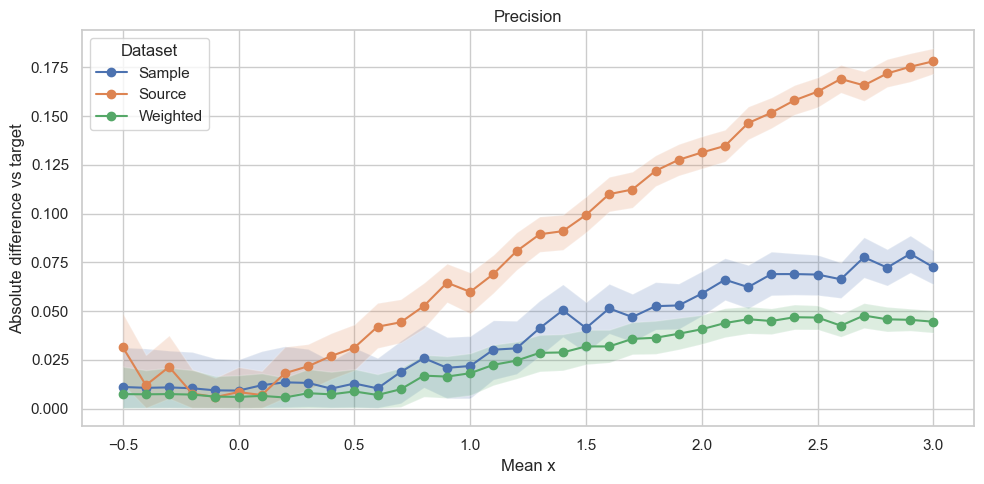

<Figure size 640x480 with 0 Axes>

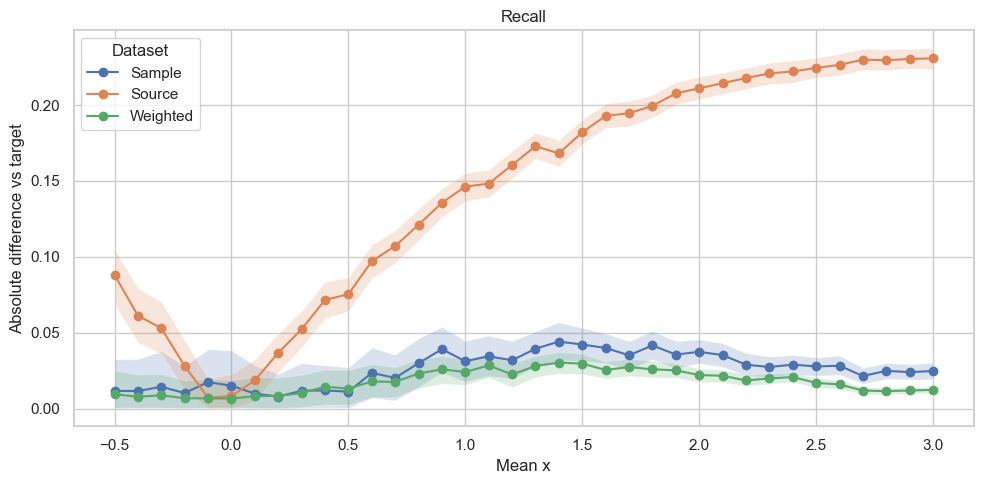

{'precision': <Figure size 640x480 with 0 Axes>,
 'recall': <Figure size 640x480 with 0 Axes>}

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_metric_differences(
    results_plot,
    metrics=['precision', 'recall'],
    x_label="Mean x",
    y_label="Absolute difference vs target",
    title_prefix=""
)


### P(Y) shift 

In [9]:
fixed_params = {
    "n": 10000,
    "p": 3,
}

# Define the range of prop_A values from 0.5 to 0.01 in steps of -0.01
p_y_values = np.round(np.arange(0.1, 0.9, 0.03), 2) 

experiment_settings = []

for p_y_value in p_y_values:
    setting = {
        "beta_1": [1, 1, 1],
        "beta_2": 2,
        "intercept": -2,
        "prop_A": 0.5,
        "mu_A0": [0, 0, 0],  
        "mu_A1": [0, 0, 0],  
        "sigma": 2.0,
        "target_p_y":p_y_value,
    }
    experiment_settings.append(setting)

print(f"Generated {len(experiment_settings)} experiment settings.")


Generated 27 experiment settings.


In [10]:
results_plot = []

# Constants
N_SAMPLES = 5000
N_ITERS = 100
IGNORE_COLUMNS = []
SEED_BASE = 42

for i, setting in enumerate(experiment_settings, start=1):
    print(f"Running Experiment {i}")

    df_target = generate_data(
        **fixed_params,
        beta_1=setting["beta_1"],
        beta_2=setting["beta_2"],
        intercept=setting["intercept"],
        prop_A=setting["prop_A"],
        mu_A0=setting["mu_A0"],
        mu_A1=setting["mu_A1"],
        sigma=setting["sigma"],
        target_p_y=setting["target_p_y"],
        seed=SEED_BASE + i
    )

    df_target['yhat'] = model.predict(df_target.drop(columns='Y'))

    # Importance Sampling
    imp = ImportanceSampler(source=df_source_test, target=df_target, ignore_cols=IGNORE_COLUMNS)
    imp.fit()
    df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)

    # Collect datasets for metric comparison
    datasets = {
        "Source": df_source_test,
        "Target": df_target,
        "Sample": df_sample,
        "Weighted": df_weighted,
    }

    # Compute bootstrap metric differences vs Target
    results_df = summarize_metric_differences(datasets, label_col="Y", pred_col="yhat", n_bootstrap=1000)
    results_df["param_value"] = setting["target_p_y"]
    results_plot.append(results_df)

# Combine all results into one DataFrame
results_plot = pd.concat(results_plot, ignore_index=True)


Running Experiment 1
Current best logistic target prob avg at iter 1: 0.095
Running Experiment 2
Current best logistic target prob avg at iter 1: 0.095
Running Experiment 3
Current best logistic target prob avg at iter 1: 0.092
Running Experiment 4
Current best logistic target prob avg at iter 1: 0.092
Running Experiment 5
Current best logistic target prob avg at iter 1: 0.092
Running Experiment 6
Current best logistic target prob avg at iter 1: 0.092
Running Experiment 7
Current best logistic target prob avg at iter 1: 0.093
Running Experiment 8
Current best logistic target prob avg at iter 1: 0.092
Running Experiment 9
Current best logistic target prob avg at iter 1: 0.092
Running Experiment 10
Current best logistic target prob avg at iter 1: 0.092
Running Experiment 11
Current best logistic target prob avg at iter 1: 0.091
Running Experiment 12
Current best logistic target prob avg at iter 1: 0.093
Running Experiment 13
Current best logistic target prob avg at iter 1: 0.092
Running 

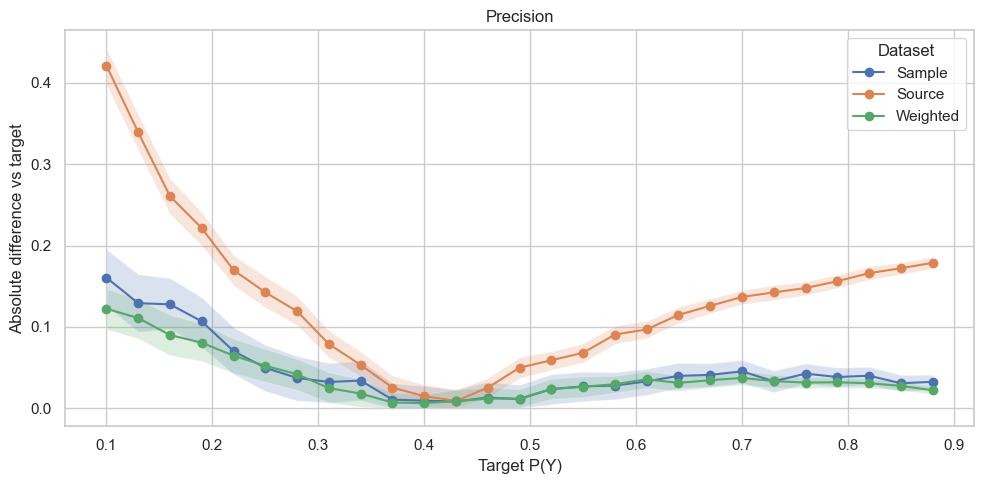

{'precision': <Figure size 640x480 with 0 Axes>}

<Figure size 640x480 with 0 Axes>

In [11]:
plot_metric_differences(
    results_plot,
    metrics=['precision'],
    x_label="Target P(Y)",
    y_label="Absolute difference vs target",
    title_prefix= ""
)


### Extreme covariate shift P(A)

In [12]:
fixed_params = {
    "n": 10000,
    "p": 3,
}

experiment_settings = [
    {
        "beta_1": [1.0, 1.0, 1.0],
        "beta_2": 2,
        "intercept": -2,
        "prop_A": 0.01,
        "mu_A0": [0, 0, 0],
        "mu_A1": [0, 0, 0],
        "sigma": 2.0,
    },
]


Running Experiment 1
Current best logistic target prob avg at iter 1: 0.143


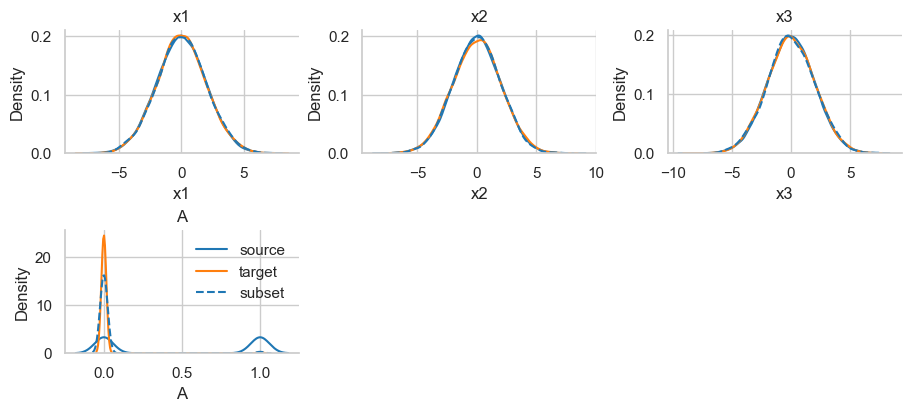

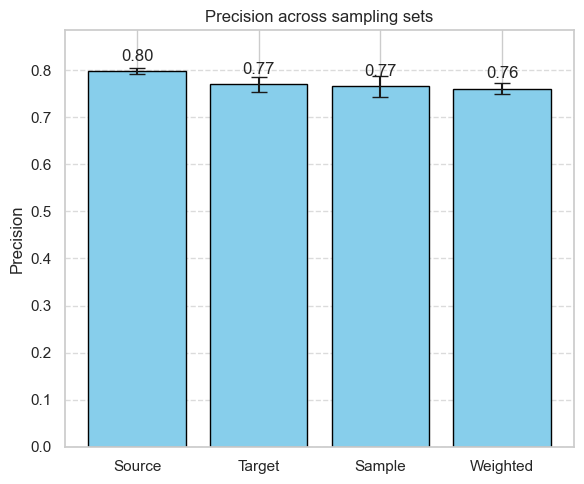

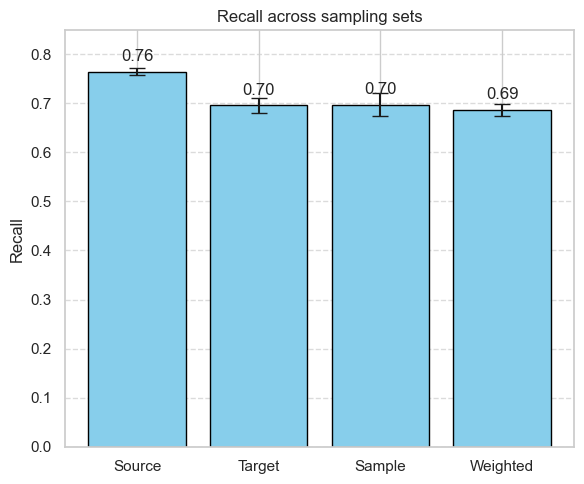

In [13]:
results_plot = []

# Constants
N_SAMPLES = 5000
N_ITERS = 100
IGNORE_COLUMNS = ['Y', 'yhat']
SEED_BASE = 42

for i, setting in enumerate(experiment_settings, start=1):
    print(f"Running Experiment {i}")

    df_target = generate_data(
        **fixed_params,
        beta_1=setting["beta_1"],
        beta_2=setting["beta_2"],
        intercept=setting["intercept"],
        prop_A=setting["prop_A"],
        mu_A0=setting["mu_A0"],
        mu_A1=setting["mu_A1"],
        sigma=setting["sigma"],
        seed=SEED_BASE + i
    )

    df_target['yhat'] = model.predict(df_target.drop(columns='Y'))

    # Importance Sampling
    imp = ImportanceSampler(source=df_source_test, target=df_target, ignore_cols=IGNORE_COLUMNS)
    imp.fit()
    df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
    imp.plot(df_sample, maxcols=3)

    # Collect datasets for metric comparison
    datasets = {
        "Source": df_source_test,
        "Target": df_target,
        "Sample": df_sample,
        "Weighted": df_weighted,
    }

    # Compute bootstrap metric differences vs Target
    results_df = summarize_all_metrics(datasets, label_col="Y", pred_col="yhat", n_bootstrap=1000)
    
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")


### Label shift P(Y)

In [1]:
fixed_params = {
    "n": 10000,
    "p": 3,
}

experiment_settings = [
    {
        "beta_1": [1.0, 1.0, 1.0],
        "beta_2": 2,
        "intercept": -2,
        "prop_A": 0.5,
        "mu_A0": [0, 0, 0],
        "mu_A1": [0, 0, 0],
        "sigma": 2.0,
        "target_p_y": 0.15,
    },
]

Running Experiment 1
0.15
Current best logistic target prob avg at iter 1: 0.539
Current best logistic target prob avg at iter 21: 0.539


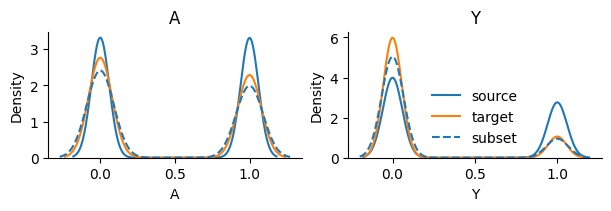

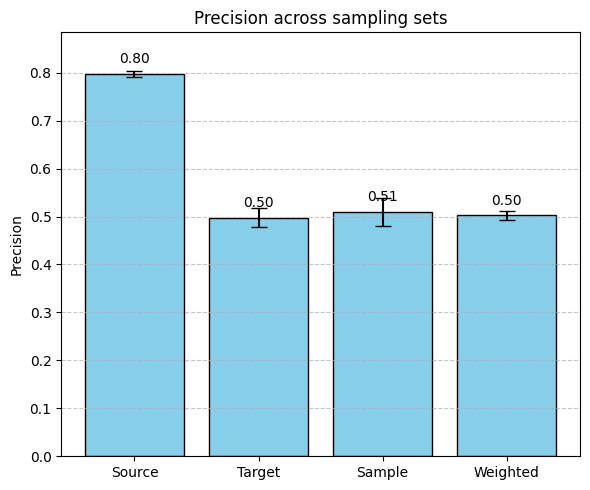

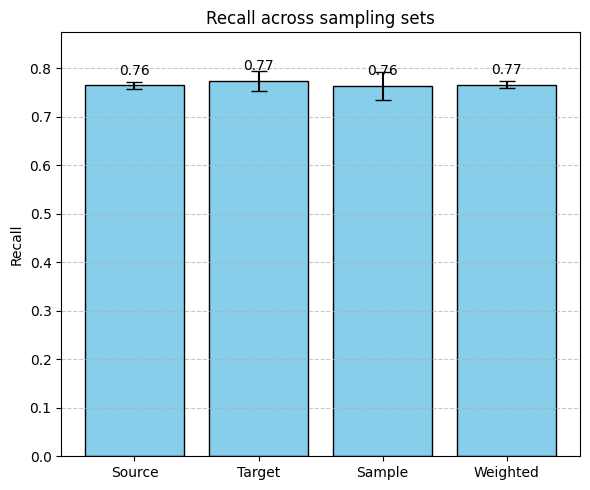

In [11]:
results_plot = []

# Constants
N_SAMPLES = 5000
N_ITERS = 100
IGNORE_COLUMNS = ['yhat', 'x1', 'x2', 'x3']
SEED_BASE = 42

for i, setting in enumerate(experiment_settings, start=1):
    print(f"Running Experiment {i}")

    df_target = generate_data(
        **fixed_params,
        beta_1=setting["beta_1"],
        beta_2=setting["beta_2"],
        intercept=setting["intercept"],
        prop_A=setting["prop_A"],
        mu_A0=setting["mu_A0"],
        mu_A1=setting["mu_A1"],
        sigma=setting["sigma"],
        target_p_y=setting["target_p_y"],
        seed=SEED_BASE + i
    )

    df_target['yhat'] = model.predict(df_target.drop(columns='Y'))
    print(df_target['Y'].mean())

    # Importance Sampling
    imp = ImportanceSampler(source=df_source_test, target=df_target, ignore_cols=IGNORE_COLUMNS)
    imp.fit()
    df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
    imp.plot(df_sample, maxcols=3)

    # Collect datasets for metric comparison
    datasets = {
        "Source": df_source_test,
        "Target": df_target,
        "Sample": df_sample,
        "Weighted": df_weighted,
    }

    # Compute bootstrap metric differences vs Target
    results_df = summarize_all_metrics(datasets, label_col="Y", pred_col="yhat", n_bootstrap=1000)
    
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")

In [12]:
print(df_source_test['Y'].mean(), df_source_test['yhat'].mean())
print(df_target['Y'].mean(), df_target['yhat'].mean())
print(df_sample['Y'].mean(), df_sample['yhat'].mean())

0.40875 0.391675
0.15 0.2335
0.1586 0.238


### Fairness evaluation 

In [16]:
# Generate new source data where group membership of A doesn't affect Y
df_source = generate_data(
    n=100000,
    p=3,
    beta_1=[1.0, 1.0, 1.0],
    beta_2=0, 
    intercept=-2,
    prop_A=0.5,
    mu_A0=[0, 0, 0],
    mu_A1=[0, 0, 0],  
    sigma=2.0,
    seed=42
)
df_source['Y'].mean()

# Initialize the model
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    df_source.drop(columns = 'Y'), df_source['Y'], df_source['A'], test_size=0.4, random_state=0)

model =  LogisticRegression()  # RandomForestClassifier()
model.fit(X_train, y_train)

yhat = model.predict(X_test)

# Only use that that is not used to fit the Logistic model 
df_source_test = pd.DataFrame(X_test, columns=X_test.columns)
df_source_test['Y'] = y_test
df_source_test['yhat'] = yhat

In [17]:
fixed_params = {
    "n": 10000,
    "p": 3,
}

experiment_settings = [
    {
        "beta_1": [1.0, 1.0, 1.0],
        "beta_2": 2,
        "intercept": -2,
        "prop_A": 0.5,
        "mu_A0": [0, 0, 0],
        "mu_A1": [-1, -1, -1],
        "sigma": 2.0,
    },
]

Running Experiment 1
Current best logistic target prob avg at iter 1: 0.112


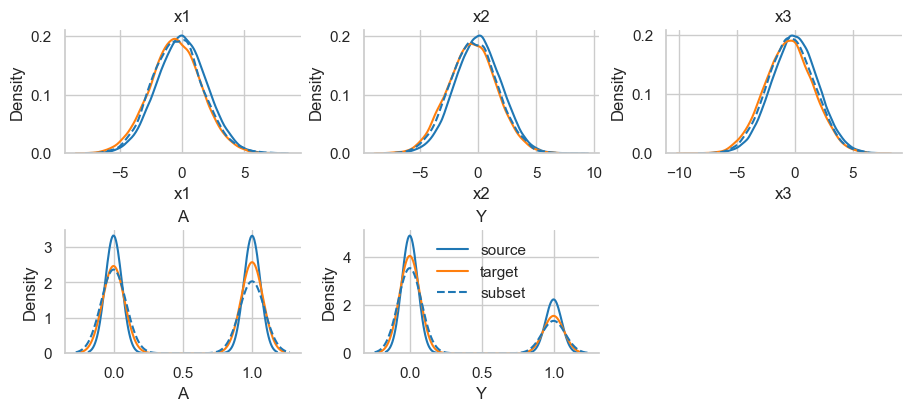

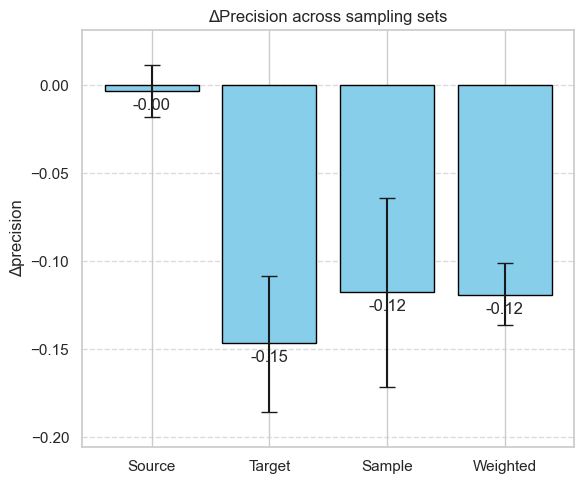

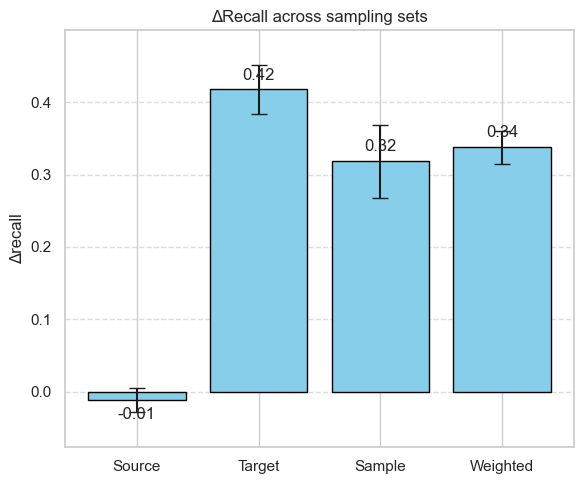

In [18]:
results_plot = []

# Constants
N_SAMPLES = 5000
N_ITERS = 100
IGNORE_COLUMNS = ['yhat']
SEED_BASE = 42

for i, setting in enumerate(experiment_settings, start=1):
    print(f"Running Experiment {i}")

    df_target = generate_data(
        **fixed_params,
        beta_1=setting["beta_1"],
        beta_2=setting["beta_2"],
        intercept=setting["intercept"],
        prop_A=setting["prop_A"],
        mu_A0=setting["mu_A0"],
        mu_A1=setting["mu_A1"],
        sigma=setting["sigma"],
        seed=SEED_BASE + i
    )

    df_target['yhat'] = model.predict(df_target.drop(columns='Y'))

    # Importance Sampling
    imp = ImportanceSampler(source=df_source_test, target=df_target, ignore_cols=IGNORE_COLUMNS)
    imp.fit()
    df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
    imp.plot(df_sample, maxcols=3)

    # Collect datasets for metric comparison
    datasets = {
        "Source": df_source_test,
        "Target": df_target,
        "Sample": df_sample,
        "Weighted": df_weighted,
    }

    # Compute bootstrap metric differences vs Target
    results_df = summarize_all_deltas(datasets, 
                                    group_col="A",
                                    group_a=0,
                                    group_b=1,
                                    label_col="Y",
                                    pred_col="yhat",
                                    n_bootstrap=1000 )

# Plot metrics
plot_metric_bars(results_df, metric="Δprecision", title="ΔPrecision across sampling sets")
plot_metric_bars(results_df, metric="Δrecall", title="ΔRecall across sampling sets")